# MODEL 1. SOIL TEXTURE CLASSIFIER

In this Notebook, a RandomForestClassifier model will be applied to the data provided by the first German soil inventory in order to automatically classify the soils according to their texture, based on the values of the provided particle size variables.

Data source:
Poeplau, C., Don, A., Flessa, H., Heidkamp, A., Jacobs, A., Prietz, R., 2020. Erste Bodenzustandserhebung Landwirtschaft – Kerndatensatz. https://doi.org/10.3220/DATA20200203151139


In [14]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para el modelo
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Load datasets

In [11]:
ruta_site = ("data//SITE.xlsx")
ruta_lab = ("data/LABORATORY_DATA.xlsx")
ruta_hor  = ("data/HORIZON_DATA.xlsx")
ruta_result=("data/suelos_alemania.xlsx")

df_hor = pd.read_excel(ruta_hor)
df_lab = pd.read_excel(ruta_lab)
df_site= pd.read_excel(ruta_site)
df_result = pd.read_excel(ruta_result)


# 2. Merge data

In [48]:
# Make lists of the differents variables
list_horizonts = list(df_hor.columns)
list_lab = list(df_lab.columns)
list_sites = list(df_site.columns)
list_results = list(df_result.columns)

In [49]:
# In order to merge df_lab and d_hor, both datasets must contain a point identifier and a horizon identifier
df_lab['HorizontID']=df_hor['HorizontID'] 

df_hor['HorizontID'] = df_hor['HorizontID'].astype(float) # Same data format

In [50]:
# Merge Dataframes
df_unido = df_lab.merge(df_hor, on=['PointID', 'HorizontID'], how='left')

In [51]:
# To organize new variables
list_unido = list(df_unido.columns)

# 3. Process NaN data

In [52]:
# Calculate the percentages of NaN in each columns in order to make future decisions

# Number of rows
total_filas = df_unido.shape[0]

# Nan counter
nulos = df_unido.isnull().sum()

# Percentage of Nan for columns
porcentaje = (nulos / total_filas) * 100

# Join everything in a DataFrame
null_df = pd.DataFrame({
    'Valores nulos': nulos,
    'Porcentaje (%)': porcentaje
})

# Sorting by descending percentages
null_df = null_df[null_df['Valores nulos'] > 0].sort_values(by='Porcentaje (%)', ascending=False)

# Show
print(null_df)

                              Valores nulos  Porcentaje (%)
Al_Di                                 15870       92.326488
Fe_Di                                 15870       92.326488
Mn_Di                                 15870       92.326488
Al_Ox                                 15452       89.894700
Fe_Ox                                 15452       89.894700
Mn_Ox                                 15452       89.894700
TS                                    14717       85.618710
Rooting intensity                      6511       37.878876
Soil colour                            3928       22.851824
Soil texture class_y                   3917       22.787829
Organic matter content class           3886       22.607482
Lower limit                            3880       22.572575
Upper limit                            3880       22.572575
Stones                                 3880       22.572575
Horizon symbol                         3880       22.572575
Carbonate class                        3

# 4. select variables

In [53]:
# Make a list wihth the variables we are going to erase: 
lista_eliminar = [
 'Layer upper limit',
 'Layer lower limit',
 'Horizon lower limit',
 'Mn_Ox',
 'Fe_Ox',
 'Al_Ox',
 'Mn_Di',
 'Fe_Di',
 'Al_Di',
 'TS',
 'Soil texture class_y',]

df_eliminados = df_unido.drop(lista_eliminar, axis=1)

We remove the metals and TS because they have many missing values and we won't focus on them. Soil texture and the limits are removed because they are duplicated.

In [54]:
list_eliminados = list(df_eliminados.columns)

In [55]:
# Organise the DataFramesorting variables in a list first: 
nuevo_orden = ['PointID', 
 'HorizontID',
 'Upper limit',
 'Lower limit',
 'Horizon symbol',
 'Rock fragment fraction',
 'Soil colour',
 'Stones',
 'Stone density',
 'Carbonate class',
 'Organic matter content class',
 'Rooting intensity',
 'gS',
 'mS',
 'fS',
 'gU',
 'mU',
 'fU',
 'Sand',
 'Silt',
 'Clay',
 'Soil texture class_x',
 'BD_FS',
 'BD_bulk',
 'FSS',
 'Water content',
 'pH_H2O',
 'EC_H2O',
 'pH_CaCl2',
 'TC',
 'TOC',
 'TIC',
 'TN',
 'County']

In [56]:
# Create our final DataFrame in a specific variables order
df = df_eliminados.reindex(columns=nuevo_orden)


In [57]:
# Null values
# We impute the missing values with the median if they are numerical and with 'Unknown' if they are categorical

for col in df.columns:
    if df[col].isnull().any():  # Si hay NaN en la columna
        if is_numeric_dtype(df[col]):  # Verifica si es numérica (int o float)
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna('Unknown')

In [58]:
df.info()
df.to_csv('df_soils.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17189 entries, 0 to 17188
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PointID                       17189 non-null  int64  
 1   HorizontID                    17189 non-null  float64
 2   Upper limit                   17189 non-null  float64
 3   Lower limit                   17189 non-null  float64
 4   Horizon symbol                17189 non-null  object 
 5   Rock fragment fraction        17189 non-null  float64
 6   Soil colour                   17189 non-null  object 
 7   Stones                        17189 non-null  object 
 8   Stone density                 17189 non-null  float64
 9   Carbonate class               17189 non-null  object 
 10  Organic matter content class  17189 non-null  object 
 11  Rooting intensity             17189 non-null  object 
 12  gS                            17189 non-null  float64
 13  m

# 5. BUILDING A MODEL TO CLASSIFY SOILS BASED ON THE VALUE OF THEIR VARIABLES

## 5.1. Create a df to visualize the kind of soils by texture class

In [59]:
variables_clase_suelo = ['gS','mS','fS','gU','mU','fU','Sand','Silt','Clay','BD_bulk', 'Soil texture class_x']

df_soil = df[variables_clase_suelo]
df_soil

,gS,mS,fS,gU,mU,fU,Sand,Silt,Clay,BD_bulk,Soil texture class_x
0,5.8,33.4,35.4,13.1,3.2,1.5,74.6,17.8,7.6,1.17,Sl2
1,6.7,32.0,35.8,13.3,3.2,1.6,74.5,18.1,7.4,1.43,Sl2
2,5.0,27.9,37.8,17.5,3.5,1.7,70.7,22.8,6.5,1.47,Sl2
3,7.6,31.4,36.6,14.4,3.0,1.2,75.6,18.6,5.8,1.48,Sl2
4,5.8,43.1,42.3,4.1,1.3,0.6,91.2,6.0,2.8,1.59,mSfs
...,...,...,...,...,...,...,...,...,...,...,...
17184,1.7,40.3,48.2,4.8,1.6,0.4,90.1,6.8,3.1,0.99,fSms
17185,1.4,39.2,49.6,6.3,1.5,0.4,90.2,8.3,1.5,1.46,fSms
17186,1.2,39.9,49.5,6.1,1.1,0.3,90.6,7.5,1.9,1.50,fSms
17187,1.2,40.9,53.5,2.7,0.5,0.2,95.5,3.3,1.2,1.63,fSms


## 5.2. Encode categorical variable (Target)

In [60]:
# Codifing the categorical target variable (Soil texture):

features = ['gS', 'mS', 'fS', 'gU', 'mU', 'fU', 'Sand', 'Silt', 'Clay', 'BD_bulk']
target = 'Soil texture class_x'

le = LabelEncoder()
df_soil['texture_encoded'] = le.fit_transform(df_soil['Soil texture class_x'])


/tmp/ipykernel_7333/1633060160.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_soil['texture_encoded'] = le.fit_transform(df_soil['Soil texture class_x'])


In [61]:
df_soil

,gS,mS,fS,gU,mU,fU,Sand,Silt,Clay,BD_bulk,Soil texture class_x,texture_encoded
0,5.8,33.4,35.4,13.1,3.2,1.5,74.6,17.8,7.6,1.17,Sl2,9
1,6.7,32.0,35.8,13.3,3.2,1.6,74.5,18.1,7.4,1.43,Sl2,9
2,5.0,27.9,37.8,17.5,3.5,1.7,70.7,22.8,6.5,1.47,Sl2,9
3,7.6,31.4,36.6,14.4,3.0,1.2,75.6,18.6,5.8,1.48,Sl2,9
4,5.8,43.1,42.3,4.1,1.3,0.6,91.2,6.0,2.8,1.59,mSfs,37
...,...,...,...,...,...,...,...,...,...,...,...,...
17184,1.7,40.3,48.2,4.8,1.6,0.4,90.1,6.8,3.1,0.99,fSms,33
17185,1.4,39.2,49.6,6.3,1.5,0.4,90.2,8.3,1.5,1.46,fSms,33
17186,1.2,39.9,49.5,6.1,1.1,0.3,90.6,7.5,1.9,1.50,fSms,33
17187,1.2,40.9,53.5,2.7,0.5,0.2,95.5,3.3,1.2,1.63,fSms,33


## 5.3. Train and test the model

In [62]:
# Separate predictors features (X) and target variable (y)
X = df_soil[features]
y = df_soil['texture_encoded']

# Creating test and train groups with train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions with the test group
y_pred = model.predict(X_test)

# Assess the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        85
           1       1.00      0.99      1.00       105
           2       0.97      0.99      0.98        90
           3       1.00      0.98      0.99       105
           4       0.99      1.00      0.99       165
           5       1.00      1.00      1.00        88
           6       1.00      0.99      0.99        72
           7       1.00      0.99      1.00       251
           9       1.00      0.99      1.00       179
          10       0.99      1.00      1.00       215
          11       1.00      1.00      1.00       232
          12       0.99      0.99      0.99        70
          13       0.97      0.94      0.95        64
          14       1.00      1.00      1.00        23
          15       1.00      0.99      0.99       170
          16       1.00      0.98      0.99        48
          17       1.00      0.89      0.94         9
          18       1.00    

## 5.4. Making a simulation with the model

In [63]:
nueva_muestra = pd.DataFrame([{
    'gS': 6.0,
    'mS': 35.0,
    'fS': 40.0,
    'gU': 15.0,
    'mU': 3.0,
    'fU': 2.0,
    'Sand': 20.0,
    'Silt': 20.0,
    'Clay': 60.0,
    'BD_bulk': 1.45,
}])

# Model prediction
pred_encoded = model.predict(nueva_muestra)

# Decode the soil texture class predicted
pred_clase = le.inverse_transform(pred_encoded)
print("Clase de textura predicha:", pred_clase[0])

Clase de textura predicha: Tl


![Triángulo de las texturas](img/Definition-of-the-German-soil-texture-classes-according-to-Ad-hoc-AG-Boden-2005-T.png)

Fig. 1. Definition of the German soil texture classes according to
Ad-hoc-AG Boden (2005). T = clay, S = sand, U = silt, L = loam; 2
= slight, 3 = medium, 4 = high

# 6. Can we reduce the number of variables?

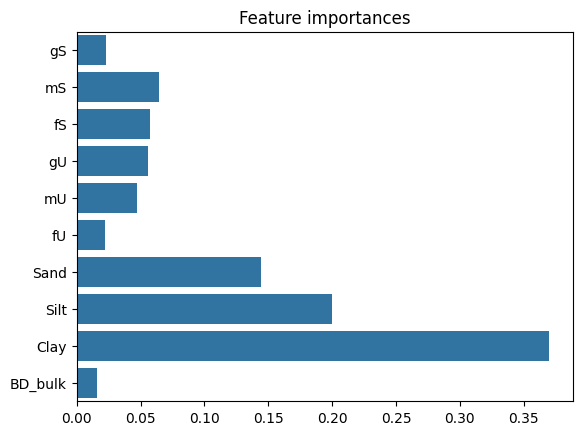

In [64]:
# Feature importances mport matplotlib.pyplot as plt
import seaborn as sns

importancias = model.feature_importances_
sns.barplot(x=importancias, y=features)
plt.title("Feature importances")
plt.show()

We can try to run the model only with Sand, silt and clay:

In [65]:
new_features = ['Sand', 'Silt', 'Clay']

X = df_soil[new_features]
y = df_soil['texture_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        85
           1       1.00      0.97      0.99       105
           2       0.97      0.99      0.98        90
           3       1.00      0.97      0.99       105
           4       0.98      1.00      0.99       165
           5       1.00      1.00      1.00        88
           6       1.00      0.97      0.99        72
           7       1.00      1.00      1.00       251
           9       1.00      0.98      0.99       179
          10       0.99      1.00      0.99       215
          11       1.00      0.99      0.99       232
          12       0.97      0.99      0.98        70
          13       0.97      1.00      0.98        64
          14       1.00      1.00      1.00        23
          15       0.99      0.99      0.99       170
          16       1.00      0.98      0.99        48
          17       1.00      1.00      1.00         9
          18       1.00    

# Conclusions

We can observe that the model can still be refined, as we have a very high accuracy and some variables, such as density, fU, or gS, do not contribute much to the model. 

We can use only silt, sand and clay features and obtain a 90% of accuracy.

# References
ISRIC. (2022). World Reference Base for Soil Resources: International soil classification system for naming soils and creating legends for soil maps (4th ed., 2022, update 2024-09-24). Food and Agriculture Organization of the United Nations (FAO). https://wrb.isric.org/files/WRB_fourth_edition_2022-12-18_errata_correction_2024-09-24.pdf

Poeplau, C., Don, A., Flessa, H., Heidkamp, A., Jacobs, A., Prietz, R., 2020. Erste Bodenzustandserhebung Landwirtschaft – Kerndatensatz. https://doi.org/10.3220/DATA20200203151139
